**Import Required Libraries**

In [1]:
import sys,os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy  
from keras.optimizers import Adam  
from keras.regularizers import l2 
from keras.utils import np_utils

**Loading, Reading, and Pre-Processing Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/My Drive/Emotion Detection")

In [4]:
os.listdir()

['archive.zip',
 'm.json',
 'Detection_Emotion.h5',
 'Emotion_detection.mp4',
 'Emotion_Detection_1.ipynb',
 'Real_Time_Detection.py',
 'AyushKesarwani_Emotion_Detection_Synopsis.pdf',
 'Explanation_Emotion_Detection_AyushKesarwani_1018652.pdf']

In [5]:
df = pd.read_csv("archive.zip")
print(df)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
X_train,train_y,X_test,test_y=[],[],[],[]  

for index, row in df.iterrows():  
    val=row['pixels'].split(" ")  
    if 'Training' in row['Usage']:
      X_train.append(np.array(val,'float32'))  
      train_y.append(row['emotion'])  
    elif 'PublicTest' in row['Usage']:  
      X_test.append(np.array(val,'float32'))  
      test_y.append(row['emotion']) 

In [8]:
num_features = 64  
num_labels = 7  
batch_size = 64  
epochs = 175
width, height = 48, 48  


X_train = np.array(X_train,'float32')  
train_y = np.array(train_y,'float32')  
X_test = np.array(X_test,'float32')  
test_y = np.array(test_y,'float32')  

train_y=np_utils.to_categorical(train_y, num_classes=num_labels)  
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)  

In [9]:
X_train -= np.mean(X_train, axis=0)  
X_train /= np.std(X_train, axis=0)  

X_test -= np.mean(X_test, axis=0)  
X_test /= np.std(X_test, axis=0)  

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)  

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1) 

**Building Model**

In [10]:
model = Sequential()  

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:]), padding='same'))  
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu', padding='same'))  
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2)))  
model.add(Dropout(0.3))  

#2nd convolution layer  
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2)))  
model.add(Dropout(0.3))  

#3rd convolution layer  
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))  
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))  
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2)))  

model.add(Flatten())  

#fully connected neural networks  
#model.add(Dense(1024, activation='relu'))  
#model.add(Dropout(0.2))  
#model.add(Dense(1024, activation='relu'))  
#model.add(Dropout(0.2))  

model.add(Dense(num_labels, activation='softmax'))  

model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

**Compiling and Training Model**

In [11]:
model.compile(loss=categorical_crossentropy,  
              optimizer=Adam(),  
              metrics=['accuracy'])  

In [12]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>=0.99):
                print("Reached 99% accuracy so cancelling training!")
                self.model.stop_training = True

callback = myCallback()

In [13]:
history = model.fit(X_train, train_y, 
          steps_per_epoch=len(X_train) / batch_size, 
          batch_size=batch_size,  
          epochs=epochs,  
          verbose=1,  
           callbacks=[callback],
          validation_data=(X_test, test_y)
          )  

Epoch 1/175
448/448 [==============================] - 14s 23ms/step - loss: 2.1030 - accuracy: 0.2962 - val_loss: 1.6188 - val_accuracy: 0.4074
Epoch 2/175
448/448 [==============================] - 10s 22ms/step - loss: 1.5318 - accuracy: 0.4428 - val_loss: 1.5544 - val_accuracy: 0.4466
Epoch 3/175
448/448 [==============================] - 10s 22ms/step - loss: 1.3614 - accuracy: 0.4981 - val_loss: 1.2433 - val_accuracy: 0.5258
Epoch 4/175
448/448 [==============================] - 10s 22ms/step - loss: 1.2176 - accuracy: 0.5456 - val_loss: 1.2731 - val_accuracy: 0.5230
Epoch 5/175
448/448 [==============================] - 10s 22ms/step - loss: 1.1311 - accuracy: 0.5816 - val_loss: 1.2343 - val_accuracy: 0.5475
Epoch 6/175
448/448 [==============================] - 10s 22ms/step - loss: 1.0442 - accuracy: 0.6165 - val_loss: 1.1790 - val_accuracy: 0.5701
Epoch 7/175
448/448 [==============================] - 10s 22ms/step - loss: 0.9750 - accuracy: 0.6365 - val_loss: 1.2135 - val_ac

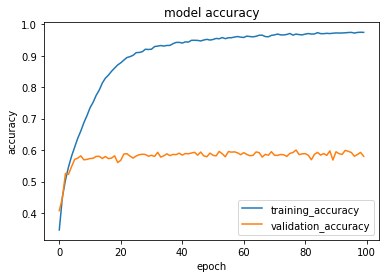

In [14]:
plt.plot(history.history['accuracy'][0:100])
plt.plot(history.history['val_accuracy'][0:100])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training_accuracy', 'validation_accuracy'], loc='lower right')
plt.show()

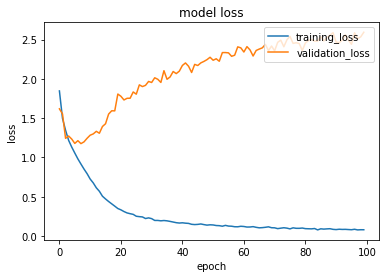

In [16]:
plt.plot(history.history['loss'][0:100])
plt.plot(history.history['val_loss'][0:100])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper right')
plt.show()

**Save Model**

In [15]:
m_json = model.to_json()  
with open("m.json", "w") as json_file:  
    json_file.write(m_json)  
model.save_weights("Detection_Emotion.h5") 

## After Saving the model, I’ll use Opencv to predict Emotions in Real-Time. But first of all, download the saved weights and model. We’ll work on our local machines now. why?? Because VideoCapture doesn’t work in google colab, in other words, using a webcam in google colab isn’t easy.


Go to Real_Time_Detection.py file.